In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

Load the data I generated from cobrapy, examples of enzymes that have both a NADH and NADPH version

In [17]:
seq_df = pd.read_csv('genes_with_sequences.csv', index_col=0)
rxn_pairs = pd.read_csv('reaction_pairs.csv')
seq_df_dedup = seq_df.drop_duplicates(subset='protein_sequence', keep=False)
seq_df_dedup = seq_df_dedup.merge(rxn_pairs.melt(value_name='reaction'), on='reaction')
seq_df_dedup['NADP'] = seq_df_dedup.variable.str.contains('nadp')
seq_df_dedup = seq_df_dedup.drop(['variable'], 1)
seq_df_dedup

,model,reaction,gene_id,protein_sequence,NADP
0,iEK1008,IPDPS,Rv3382c,MAEVFVGPVAQGYASGEVTVLLASPRSFCAGVERAIETVKRVLDVA...,False
1,iCN718,IPDPS,ABAYE_RS02095,MEIVLANPRGFCAGVDRAIAIVNRALECFNPPIYVRHEVVHNKFVV...,False
2,iLJ478,IPDPS,TM1444,MKIVVAKNIGFCFGVERAIRTVEELLDEGKKVVTDGEIVHNKQVME...,False
3,iCHOv1_DG44,DHPR,100769495,MAASGEARRVLVYGGRGALGSRCVQAFRARNWWVASIDVVENEEAS...,False
4,iMM1415,DHPR,110391,MAASGEARRVLVYGGRGALGSRCVQAFRARNWWVASIDVVENEEAS...,False
...,...,...,...,...,...
1292,iEC1356_Bl21DE3,GLUSy,ECD_RS16020,MLYDKSLERDNCGFGLIAHIEGEPSHKVVRTAIHALARMQHRGAIL...,True
1293,iCN718,GLUSy,ABAYE_RS02030,MAERLNNDFQFLDVPRQDPEKKDITVRKAEFVEIYKPFTSETVTNQ...,True
1294,iCN718,GLUSy,ABAYE_RS02025,MHMPSPNTVAPAQGLYQPDEFKDNCGFGLIAHMKGESSHHLVETAI...,True
1295,iEC1349_Crooks,GLUSy,ECOLC_RS02600,MLYDKSLERDNCGFGLIAHIEGEPSHKVVRTAIHALARMQHRGAIL...,True


I'm running this on the GPU nodes, but the code shouldn't have to change too much for the CPU nodes

In [18]:
import torch
torch.cuda.is_available()

True

Generate protein-level feature vectors using [ESM](https://github.com/facebookresearch/esm)

In [30]:
torch.hub.set_dir('/tmp/.cache/torch')
model, alphabet = torch.hub.load("facebookresearch/esm", "esm1_t6_43M_UR50S")

batch_converter = alphabet.get_batch_converter()
batch_labels, batch_strs, batch_tokens = batch_converter(list(seq_df_dedup.protein_sequence.items()))

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
batch_dataloader = torch.utils.data.DataLoader(batch_tokens, batch_size=8)

from tqdm import tqdm

output = []
with torch.no_grad():
    for batch in tqdm(batch_tokens):
        result = model(batch.to(device), repr_layers=[6])  # because this is the 6-layer transformer
        output += [result['representations'][6].detach().cpu().numpy()]

outputs = np.vstack(output)

# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
representations = []
for output, seq in zip(outputs, seq_df_dedup.protein_sequence):
    representations += [output[1 : len(seq) + 1].mean(0)]
    
representations = np.vstack(representations)
representations.shape

Run a logistic regression and plot the precision recall curve

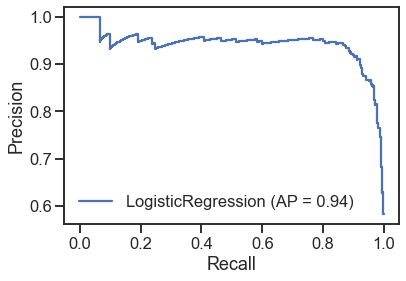

In [142]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = representations
y = seq_df_dedup.NADP.astype(float)

# Reserve 20% of the data for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(log_reg, X_test, y_test)